<a href="https://colab.research.google.com/github/Purushotham-Mani/CS237A/blob/main/MT/p1_lqr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting up Dynamics for the Bicycle Model

In [ ]:
import typing as T
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.linalg import solve_continuous_are as ricatti_solver

class BicycleModel:

    def __init__(self, obstacles: T.List) -> None:
        """
        Initializes the bicycle model parameters, including the state and control
        dimensions, the length of the bicycle, control constraints for speed and steering rate,
        and obstacles to be avoided.
        """
        self.x_dim = 4    # state dimension
        self.u_dim = 2    # control dimension
        self.l = 0.6      # length

        # control constraints
        self.v_min = 0.01
        self.v_max = 2.0

        self.omega_min = -2.0
        self.omega_max = 2.0

        # obstacles
        self.obstacles = obstacles

    def discrete_step(self, state: np.ndarray, control: np.ndarray, dt: float) -> np.ndarray:
        """
        Simulates a discrete-time step for the bicycle model using Euler integration.

        Args:
            state (np.ndarray): Current state [qx, qy, theta, phi]
            control (np.ndarray): Control input [v, omega]
            dt (float): Time step

        Returns:
            new_state (np.ndarray): Updated state after time step dt.
        """
        assert len(state) == self.x_dim
        assert len(control) == self.u_dim

        qx, qy, theta, phi = state
        v, omega = control

        dstate_dt = np.array([
            v * np.cos(theta),
            v * np.sin(theta),
            v / self.l * np.tan(phi),
            omega
        ])

        new_state = state + dstate_dt * dt
        return new_state

    def simulate_nominal(self, initial_state: np.ndarray, nominal_controls: np.ndarray, dt: float) -> np.ndarray:
        """
        Simulates a sequence of nominal states using the control inputs in open loop.

        Args:
            initial_state (np.ndarray): Initial state of the system.
            nominal_controls (np.ndarray): Array of control inputs for each time step.
            dt (float): Time step duration.

        Returns:
            np.ndarray: Array of simulated states following the nominal trajectory.
        """
        states = [initial_state]
        N = len(nominal_controls)
        for i in range(N):
            states.append(self.discrete_step(states[i], nominal_controls[i], dt))
        return np.array(states)

    def simulate_open_loop(
            self,
            initial_state: np.ndarray,
            nominal_controls: np.ndarray,
            control_noises: np.ndarray,
            dt: float
        ) -> np.ndarray:
        """
        Simulates an open-loop trajectory with added control noise.

        Args:
            initial_state (np.ndarray): Initial state of the system.
            nominal_controls (np.ndarray): Array of nominal control inputs.
            control_noises (np.ndarray): Array of noise to be added to each control input.
            dt (float): Time step duration.

        Returns:
            np.ndarray: Array of simulated states with open-loop control and noise.
        """
        states = [initial_state]
        N = len(nominal_controls)
        for i in range(N):
            noisy_control = nominal_controls[i] + control_noises[i]
            states.append(self.discrete_step(states[i], noisy_control, dt))
        return np.array(states)

    def get_jacobians(self, state: np.ndarray, control: np.ndarray) -> T.Tuple[np.ndarray, np.ndarray]:
        """
        Computes the continuous-time Jacobian matrices A and B of the bicycle model.

        Args:
            state (np.ndarray): Current state [qx, qy, theta, phi]
            control (np.ndarray): Control input [v, omega]

        Returns:
            A, B (T.Tuple[np.ndarray, np.ndarray]): The state Jacobian (A) and control Jacobian (B) matrices.
        """
        assert len(state) == self.x_dim
        assert len(control) == self.u_dim

        qx, qy, theta, phi = state
        v, omega = control

        '''
        Compute the continuous-time state Jacobian A and control Jacobian B
        '''
        ########## Code starts here ##########
        A = np.array([[0, 0 , -v*np.sin(theta), 0],[0, 0 , v*np.cos(theta), 0], [0, 0, 0, v/self.l*(1/np.cos(phi))**2],[0,0,0,0]])
        B = np.array([[np.cos(theta), 0], [np.sin(theta), 0], [np.tan(phi)/self.l, 0], [0,1]])
        ########## Code ends here ##########
        return A, B

    def find_closest_nominal_state(self, current_state: np.ndarray, nominal_states: np.ndarray) -> int:
        """
        Finds the index of the nominal state closest to the current state based on L2 distance.

        Args:
            current_state (np.ndarray): The current state of the system.
            nominal_states (np.ndarray): Array of nominal states to compare against.

        Returns:
            closest_state_idx (int): Index of the closest nominal state.
        """
        ########## Code starts here ##########
        closest_state_idx = np.argmin(np.linalg.norm(nominal_states - current_state, axis=1))
        ########## Code ends here ##########
        return closest_state_idx

    def get_gains_lookup(
            self,
            nominal_states: np.ndarray,
            nominal_controls: np.ndarray,
            Q: np.ndarray,
            R: np.ndarray
        ) -> T.Dict[int, np.ndarray]:
        """
        Computes and stores the gain matrices for each nominal state using LQR.

        Args:
            nominal_states (np.ndarray): Array of nominal states.
            nominal_controls (np.ndarray): Array of nominal control inputs.
            Q (np.ndarray): State cost matrix for LQR.
            R (np.ndarray): Control cost matrix for LQR.

        Returns:
            gains_lookup (T.Dict[int, np.ndarray]): Dictionary of gain matrices for each nominal state.
        """
        gains_lookup = {}
        for i in range(len(nominal_states)):
            '''
            1. Set a small control for the last state as nominal control is undefined for it.
            2. Compute Jacobians and use the imported ricatti_solver function to get P.
            3. Compute and store the gain matrix.
            '''
            ########## Code starts here ##########
            if i == len(nominal_states) - 1:
                control = np.array([self.v_min, 0])
                A, B = self.get_jacobians(nominal_states[i], control)
                P = ricatti_solver(A, B, Q, R)
            else:
                control = nominal_controls[i]
                A, B = self.get_jacobians(nominal_states[i], control)
                P = ricatti_solver(A, B, Q, R)
            gains_lookup[i] = np.matmul(np.linalg.inv(R),np.matmul(B.T,P.T))
            ########## Code ends here ##########
        return gains_lookup

    def simulate_closed_loop(
            self,
            initial_state: np.ndarray,
            nominal_states: np.ndarray,
            nominal_controls: np.ndarray,
            control_noises: np.ndarray,
            dt: float,
            gains_lookup: T.Dict[int, np.ndarray],
        ) -> np.ndarray:
        """
        Simulates the closed-loop trajectory using LQR.

        Args:
            initial_state (np.ndarray): Initial state of the system.
            nominal_states (np.ndarray): Array of nominal states for the trajectory.
            nominal_controls (np.ndarray): Array of nominal control inputs.
            control_noises (np.ndarray): Array of noise to be added to each control input.
            dt (float): Time step duration.
            gains_lookup (T.Dict[int, np.ndarray]): Precomputed gain matrices for LQR control.

        Returns:
            np.ndarray: Array of simulated states with closed-loop control.
        """
        states = [initial_state]
        N = len(nominal_controls)
        for i in range(N):
            '''
            1. Find the closest nominal state and corresponding gain matrix.
            2. Compute the adjusted control with LQR feedback.
            '''
            ########## Code starts here ##########
            closest_state_idx = self.find_closest_nominal_state(states[i], nominal_states)
            gain = gains_lookup[closest_state_idx]
            control = nominal_controls[i] - np.matmul(gain, states[i] - nominal_states[closest_state_idx])
            ########## Code ends here ##########
            control = np.clip(control, [self.v_min, self.omega_min], [self.v_max, self.omega_max])
            noisy_control = control + control_noises[i]
            next_state = self.discrete_step(states[i], noisy_control, dt)
            states.append(next_state)
        return np.array(states)

    def plot_obstacles(self, ax: matplotlib.axes.Axes) -> None:
        """
        Plots circular obstacles on the given axis.
        """
        for obstacle in self.obstacles:
            obs = matplotlib.patches.Circle(obstacle[0], obstacle[1], facecolor="k")
            ax.add_patch(obs)

# Computing a Nominal Trajectory

In [ ]:
import scipy.optimize

def optimize_nominal_trajectory(
        bicycle_model: BicycleModel,
        x_0: np.ndarray,
        x_f: np.ndarray,
        N: int = 50,
        time_weight: float = 1.0,
        return_optimize_result: bool = False
    ):
    """
    Optimizes the nominal trajectory of the bicycle model.

    Args:
        bicycle_model (BicycleModel): The bicycle model to be optimized.
        x_0 (np.ndarray): Initial state [qx, qy, theta, phi].
        x_f (np.ndarray): Final desired state [qx, qy, theta, phi].
        N (int): Number of discrete steps in the trajectory.
        time_weight (float): Weight on the total trajectory time in the cost function.
        return_optimize_result (bool): If True, returns the full optimization result, otherwise returns only the optimized trajectory.

    Returns:
        If return_optimize_result is False:
            final_time (float): Optimized time duration for the trajectory.
            states (np.ndarray): Array of shape (N + 1, x_dim) with the optimized states.
            controls (np.ndarray): Array of shape (N, u_dim) with the optimized control inputs.
        If return_optimize_result is True:
            result (OptimizeResult): Full result from the optimization.
    """
    x_dim = bicycle_model.x_dim
    u_dim = bicycle_model.u_dim

    def pack_decision_variables(final_time: float, states: np.ndarray, controls: np.ndarray) -> np.ndarray:
        """
        Packs decision variables (final_time, states, controls) into a 1D vector.

        Args:
            final_time (float): Total time for trajectory.
            states (np.ndarray): Array of shape (N + 1, x_dim) representing the state trajectory.
            controls (np.ndarray): Array of shape (N, u_dim) representing the control inputs.

        Returns:
            np.ndarray: Packed decision variables as a 1D vector.
        """
        return np.concatenate([[final_time], states.ravel(), controls.ravel()])

    def unpack_decision_variables(z: np.ndarray) -> T.Tuple[float, np.ndarray, np.ndarray]:
        """
        Unpacks a 1D vector into decision variables (final_time, states, controls).

        Args:
            z (np.ndarray): Array of packed decision variables.

        Returns:
            final_time (float): Total time for trajectory.
            states (np.ndarray): State trajectory of shape (N + 1, x_dim).
            controls (np.ndarray): Control inputs of shape (N, u_dim).
        """
        final_time = z[0]
        states = z[1 : 1 + (N + 1) * x_dim].reshape(N + 1, x_dim)
        controls = z[-N * u_dim:].reshape(N, u_dim)
        return final_time, states, controls

    def cost(z: np.ndarray) -> float:
        """
        Cost function for the optimization, balancing time and control effort.

        Args:
            z (np.ndarray): Packed decision variables.

        Returns:
            float: Computed cost for the given trajectory.
        """
        final_time, states, controls = unpack_decision_variables(z)
        dt = final_time / N
        return time_weight * final_time + dt * np.sum(np.square(controls))

    def equality_constraints(z: np.ndarray) -> np.ndarray:
        """
        Equality constraints for the optimization, ensuring the initial and final states match desired states,
        and enforcing dynamics constraints at each step.

        Args:
            z (np.ndarray): Packed decision variables.

        Returns:
            np.ndarray: Concatenated array of constraints, expected to be zero when satisfied.
        """
        final_time, states, controls = unpack_decision_variables(z)
        dt = final_time / N
        constraint_list = [states[i + 1] - bicycle_model.discrete_step(states[i], controls[i], dt) for i in range(N)]
        constraint_list.append(states[0] - x_0)
        constraint_list.append(states[-1] - x_f)
        return np.concatenate(constraint_list)

    def inequality_constraints(z: np.ndarray) -> np.ndarray:
        """
        Inequality constraints for obstacle avoidance.

        Args:
            z (np.ndarray): Packed decision variables.

        Returns:
            np.ndarray: Concatenated array of obstacle avoidance constraints.
        """
        final_time, states, controls = unpack_decision_variables(z)
        half_length = bicycle_model.l / 2.0

        # Center position of the bicycle
        xc = states[:, 0] + half_length * np.cos(states[:, 2])
        yc = states[:, 1] + half_length * np.sin(states[:, 2])
        centre = np.column_stack((xc, yc))

        # Collision avoidance
        constraint_list = []
        for obstacle in bicycle_model.obstacles:
            obs = np.sum(np.square(centre - np.array(obstacle[0])), -1) - (obstacle[1] + half_length) ** 2
            constraint_list.append(obs)
        return np.concatenate(constraint_list)

    z_guess = pack_decision_variables(10.0, x_0 + np.linspace(0, 1, N + 1)[:, np.newaxis] * (x_f - x_0), np.ones((N, u_dim)))

    bounds = scipy.optimize.Bounds(
        pack_decision_variables(0.0, -np.inf * np.ones((N + 1, x_dim)), np.array([bicycle_model.v_min, bicycle_model.omega_min]) * np.ones((N, u_dim))),
        pack_decision_variables(np.inf, np.inf * np.ones((N + 1, x_dim)), np.array([bicycle_model.v_max, bicycle_model.omega_max]) * np.ones((N, u_dim)))
    )

    result = scipy.optimize.minimize(cost,
                                     z_guess,
                                     bounds=bounds,
                                     constraints=[{
                                         "type": "eq",
                                         "fun": equality_constraints
                                     }, {
                                         "type": "ineq",
                                         "fun": inequality_constraints
                                     }])
    if return_optimize_result:
        return result
    else:
        return unpack_decision_variables(result.x)

In [ ]:
# Obstacles
obstacles = [
    ((2.0, 1.5), 0.6),
    ((3.0, 3.0), 0.5),
    ((1.5, 3.5), 0.4),
]

# Optimizing for a nominal trajectory
bicycle_model = BicycleModel(obstacles)
x_0 = np.array([0.5, 0.5, 0.0, 0.0]) # initial state
x_f = np.array([3.5, 4.0, 0.0, 0.0]) # final state
final_time, nominal_states, nominal_controls = optimize_nominal_trajectory(bicycle_model, x_0, x_f, N=50, time_weight=2.0)
dt = final_time / len(nominal_controls)

# Open-loop control, nominal conditions

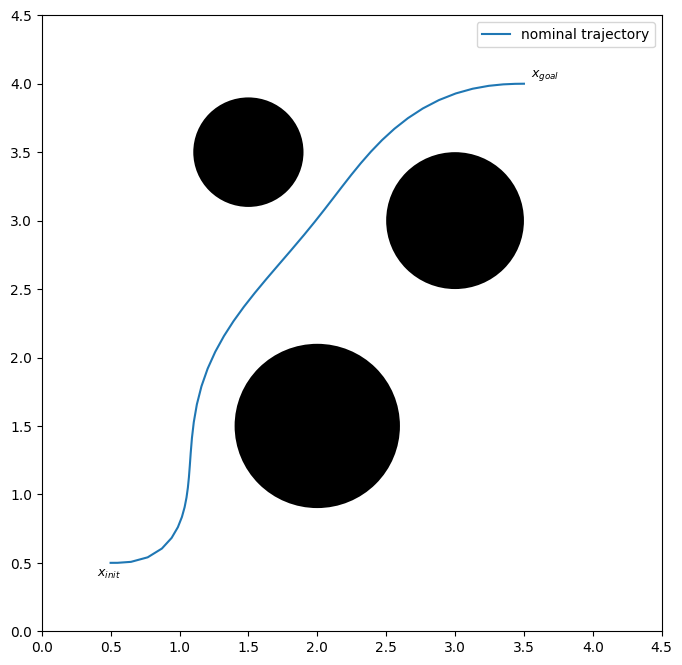

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xlim(0, 4.5)
ax.set_ylim(0, 4.5)

states = bicycle_model.simulate_nominal(nominal_states[0], nominal_controls, dt)
plt.plot(states[:, 0], states[:, 1], label='nominal trajectory')
plt.annotate(r"$x_{init}$", x_0[:2] + [-0.1, -0.1], fontsize=9)
plt.annotate(r"$x_{goal}$", x_f[:2] + [0.05, 0.05], fontsize=9)
plt.legend()
bicycle_model.plot_obstacles(ax)

# Simulating Open-loop control with disturbance

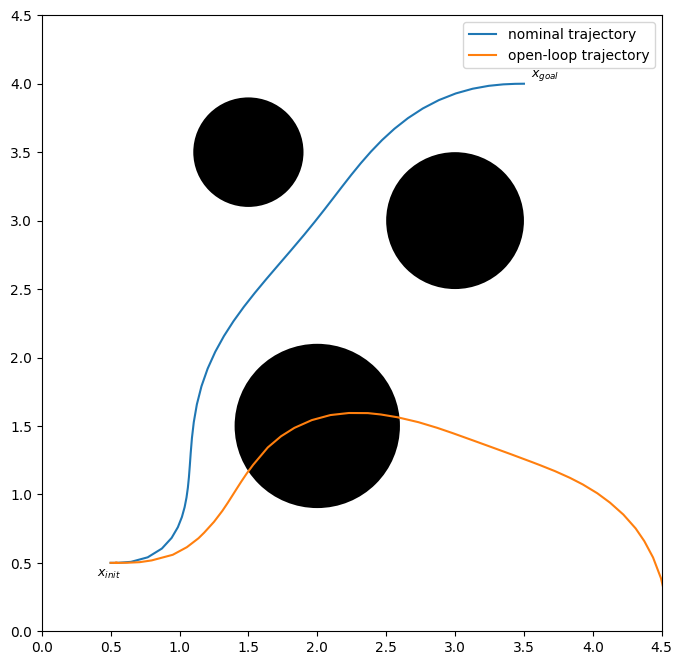

In [ ]:
np.random.seed(1)
noise_level = 0.3
control_noises = noise_level * np.random.randn(*nominal_controls.shape)

fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xlim(0, 4.5)
ax.set_ylim(0, 4.5)

states = bicycle_model.simulate_nominal(nominal_states[0], nominal_controls, dt)
open_loop_states = bicycle_model.simulate_open_loop(nominal_states[0], nominal_controls, control_noises, dt)
plt.plot(states[:, 0], states[:, 1], label='nominal trajectory')
plt.plot(open_loop_states[:, 0], open_loop_states[:, 1], label='open-loop trajectory')
plt.annotate(r"$x_{init}$", x_0[:2] + [-0.1, -0.1], fontsize=9)
plt.annotate(r"$x_{goal}$", x_f[:2] + [0.05, 0.05], fontsize=9)
plt.legend()
bicycle_model.plot_obstacles(ax)

# LQR Control and Gain Scheduling
## Attach the generated plot `p1_lqr.png` in your write-up

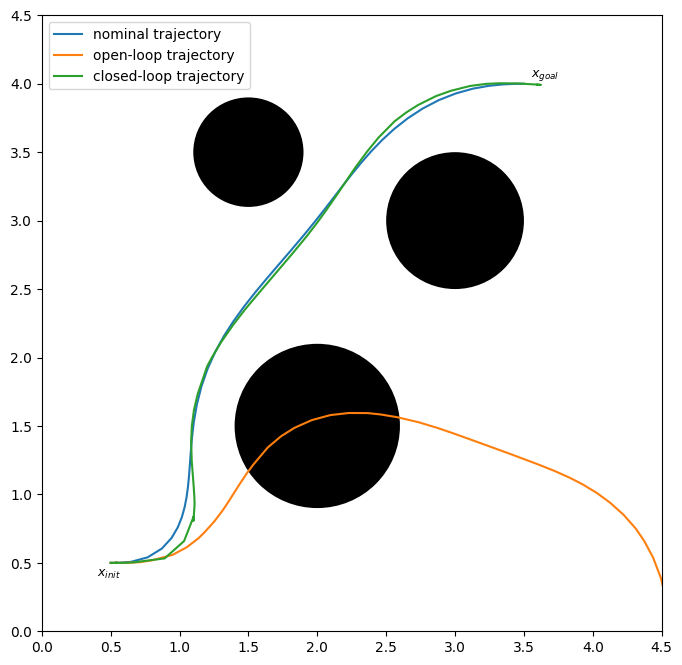

In [ ]:
Q = 100 * np.diag([1.0, 1.0, 1.0, 1.0])
R = 1e0 * np.diag([1.0, 1.0])
gains_lookup = bicycle_model.get_gains_lookup(nominal_states, nominal_controls, Q, R)

fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xlim(0, 4.5)
ax.set_ylim(0, 4.5)

states = bicycle_model.simulate_nominal(nominal_states[0], nominal_controls, dt)
open_loop_states = bicycle_model.simulate_open_loop(nominal_states[0], nominal_controls, control_noises, dt)
closed_loop_states = bicycle_model.simulate_closed_loop(nominal_states[0], nominal_states, nominal_controls, control_noises, dt, gains_lookup)
plt.plot(states[:, 0], states[:, 1], label='nominal trajectory')
plt.plot(open_loop_states[:, 0], open_loop_states[:, 1], label='open-loop trajectory')
plt.plot(closed_loop_states[:, 0], closed_loop_states[:, 1], label='closed-loop trajectory')
plt.annotate(r"$x_{init}$", x_0[:2] + [-0.1, -0.1], fontsize=9)
plt.annotate(r"$x_{goal}$", x_f[:2] + [0.05, 0.05], fontsize=9)
plt.legend()
bicycle_model.plot_obstacles(ax)
plt.savefig("p1_lqr.png")